In [1]:
import os
import re
import glob
import pandas as pd
import numpy as np

In [2]:
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import tqdm
from PIL import Image

import albumentations as A
import albumentations.pytorch as AP
from albumentations.augmentations.geometric import rotate as AR

## Display_image()

In [3]:
def display_images(dataloader, title, batch_size = None, 
                    denorm = False, 
                    denorm_mean = (0.485, 0.456, 0.406),   
                    denorm_std = (0.229, 0.224, 0.225)):
    
    if batch_size is None:
        batch_size = math.ceil(len(dataloader.dataset)/len(dataloader))
        
    samples, labels = iter(dataloader).next()
    new = []    # to store new tensors after editing numpy array to add the target in the image
    for img, y in zip(samples, labels):

        
        if denorm == False:
            # convert tensor to numpy, shape to (H,W,C), dtype to (uint8/uint16/int16/int32)
            # copy() will make it a contigous array 
            img = img.numpy().transpose(1,2,0).astype(np.int16).copy()
        
        if denorm == True:
            # convert tensor to numpy, shape to (H,W,C)
            img = img.numpy().transpose(1,2,0)

            # denormalize images
            img[:,:,0] = (img[:,:,0] * 255 * denorm_std[0]) + (255 * denorm_mean[0])
            img[:,:,1] = (img[:,:,1] * 255 * denorm_std[1]) + (255 * denorm_mean[1])
            img[:,:,2] = (img[:,:,2] * 255 * denorm_std[2]) + (255 * denorm_mean[2])

            # convert dtype to  (uint8/uint16/int16/int32)
            # copy() will make it a contigous array 
            img = img.astype(np.int16).copy()
        

        # put target value on the image
        cv2.putText(img, f"{y.int()}", (10,20), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,0),2)

        # convert to tensor (c,h,w)
        img = torch.tensor(img.transpose(2,0,1).astype(np.float32))

        # create list of tensors
        new.append(img)

    # convert list of 3d tensors to 4d tensor
    samples = torch.stack(new)
    plt.figure(figsize=(18,18))
    grid_imgs = make_grid(samples[:batch_size], nrow = 6)
    np_grid_imgs = grid_imgs.numpy()

    # pytorch requires torch tensor of shape (c,h,w) & dtype float
    # plt requires numpy array of shape (h,w,c) & dtype int
    plt.imshow(np.transpose(np_grid_imgs, (1,2,0)).astype(int))
    plt.title(title)
    plt.show()

## Create Dataframe of input files

In [4]:
input_path = '/kaggle/input/hand-cricket-dataset/hand-signal/input'
files = glob.glob(os.path.join(input_path, '*'))
print(len(files))
df = pd.DataFrame()
df['file_path'] = files

def target(x):
    file_name = x.split('/')[-1]
    # print(file_name)
    target = re.findall(r"(\d)", file_name)[0]
    return target
    
    
df['target'] = df['file_path'].apply(lambda x:target(x))
df = df.sample(frac=1, random_state = 42)
df.to_csv('/kaggle/working/train.csv', index = False)
df = pd.read_csv('/kaggle/working/train.csv')

print(df.head(20))

1848
                                            file_path  target
0   /kaggle/input/hand-cricket-dataset/hand-signal...       6
1   /kaggle/input/hand-cricket-dataset/hand-signal...       3
2   /kaggle/input/hand-cricket-dataset/hand-signal...       2
3   /kaggle/input/hand-cricket-dataset/hand-signal...       0
4   /kaggle/input/hand-cricket-dataset/hand-signal...       5
5   /kaggle/input/hand-cricket-dataset/hand-signal...       2
6   /kaggle/input/hand-cricket-dataset/hand-signal...       0
7   /kaggle/input/hand-cricket-dataset/hand-signal...       4
8   /kaggle/input/hand-cricket-dataset/hand-signal...       1
9   /kaggle/input/hand-cricket-dataset/hand-signal...       2
10  /kaggle/input/hand-cricket-dataset/hand-signal...       4
11  /kaggle/input/hand-cricket-dataset/hand-signal...       4
12  /kaggle/input/hand-cricket-dataset/hand-signal...       0
13  /kaggle/input/hand-cricket-dataset/hand-signal...       1
14  /kaggle/input/hand-cricket-dataset/hand-signal...       5
15 

## Create Pytorch dataset

In [5]:
class ClassificationDataset(Dataset):
    def __init__(self, file_paths, targets, augmentations = None):
        self.files = file_paths
        self.targets = targets  
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        target = self.targets[idx]
        
        # convert to numpy array
        img = np.array(img)
        
        # transform img using albumentations 
        # alb requires input to be numpy array
        if (self.augmentations):
            augmented = self.augmentations(image=img)
            img = augmented["image"]
        
        # pytorch requires image in format (#channels, H, W).
        # currently image is in form (H,W,C)
        img = img.transpose(2,0,1).astype(np.float32)
                
        return (torch.tensor(img, dtype=torch.float), 
                torch.tensor(target, dtype=torch.long))

1663 185 1663 185


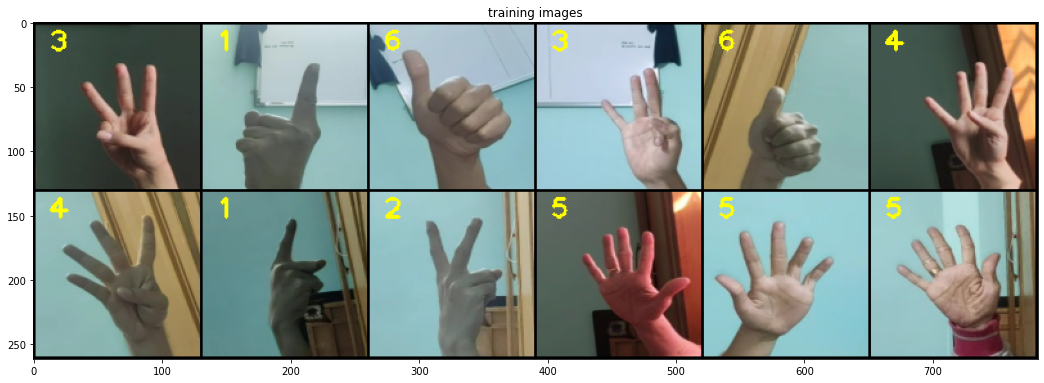

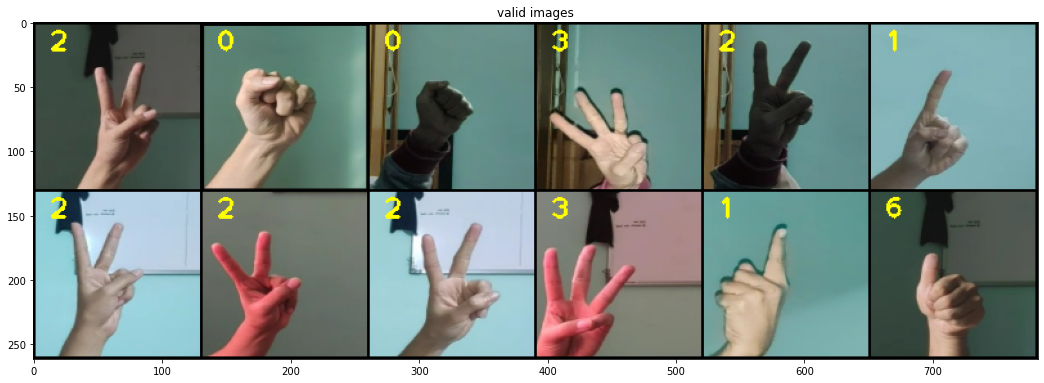

In [6]:
df = pd.read_csv('/kaggle/working/train.csv')

images = df['file_path'].values.tolist()
targets = df['target'].values

train_transform = A.Compose([
    AR.Rotate(limit = 30),
    A.Resize(128, 128),
    A.HorizontalFlip(),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225), max_pixel_value = 255.0, always_apply=True
)
])

valid_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225), max_pixel_value = 255.0, always_apply=True
)
])


train_images, valid_images, train_targets, valid_targets = train_test_split(images, 
                                                                            targets,
                                                                            test_size = 0.1, 
                                                                            stratify = targets,
                                                                            random_state = 42)
print(len(train_images), len(valid_images), len(train_targets), len(valid_targets))

train_data = ClassificationDataset(train_images, train_targets, augmentations = train_transform)
trainloader = DataLoader(train_data, batch_size = 12, shuffle = True, num_workers = 2)
display_images(trainloader, 'training images', batch_size = 12, denorm = True)

valid_data = ClassificationDataset(valid_images, valid_targets, augmentations = valid_transform)
validloader = DataLoader(valid_data, batch_size = 12, shuffle = True, num_workers = 2)
display_images(validloader, 'valid images', batch_size = 12, denorm = True)

## Define model

In [7]:
model = torchvision.models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    # when using CrossEntropyLoss(), the output from NN should be logit values for each class
    # nn.Linear(500,1)
    # when using BCEWithLogitsLoss(), the output from NN should be logit value for True label
    nn.Linear(500, 7)
)

device = torch.device('cuda')
model = model.to(device)  

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

## Define optimizer

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

## Define train() and validate()

In [9]:
def train(model, trainloader, optimizer, device):
    criterion = nn.CrossEntropyLoss() 
    epoch_loss = []
    epoch_acc = []
    model.train()
    for samples, labels in trainloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(samples)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # pred = (outputs>0).float()

        pred = torch.argmax(outputs, dim=1)
        correct = pred.eq(labels)
        acc = torch.mean(correct.float())
        
        epoch_loss.append(loss.cpu().item())    # bring to cpu and get the value
        epoch_acc.append(acc.cpu().item())
        
    avg_train_loss = np.mean(epoch_loss)
    avg_train_acc = np.mean(epoch_acc)
        
    print(f'Train Loss: {avg_train_loss:.3f}, Train Accuracy: {avg_train_acc:.3f}', end = " ")

    return avg_train_loss, avg_train_acc

def validate(model, validloader, device):
    criterion = nn.CrossEntropyLoss() 
    epoch_loss = []
    epoch_acc = []

    # model.eval() will notify all your layers that you are in eval mode, that way, 
    # batchnorm or dropout layers will work in eval mode instead of training mode.

    # torch.no_grad() impacts the autograd engine and deactivate it. It will reduce 
    # memory usage and speed up computations but you won’t be able to backprop 
    # (which you don’t want in an eval script).

    model.eval()
    with torch.no_grad():
        for samples, labels in validloader:
            samples, labels = samples.to(device), labels.to(device)
            outputs = model(samples)
            loss = criterion(outputs, labels)

#             pred = (outputs>0).float()   # when using BCELoss

            pred = torch.argmax(outputs, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            epoch_loss.append(loss.cpu().item())
            epoch_acc.append(acc.cpu().item())
    
    avg_valid_loss = np.mean(epoch_loss)
    avg_valid_acc = np.mean(epoch_acc)
        
    print(f'| Valid Loss: {avg_valid_loss:.3f}, Valid Accuracy: {avg_valid_acc:.3f}')

    return avg_valid_loss, avg_valid_acc

## Train the model

In [10]:
train_losses = []
valid_losses = []
min_loss = np.inf
epochs = 40

for epoch in range(epochs):
    print(f'[Epoch {epoch+1}/{epochs}]:')
    train_loss, _ = train(model, trainloader, optimizer, device)
    valid_loss, _ = validate(model, validloader, device)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if (valid_loss<min_loss):
        print("Loss decreased. Saving model...")
        min_loss = valid_loss
        torch.save(model.state_dict(), '/kaggle/working/hand-cricket_model.pth')

[Epoch 1/40]:
Train Loss: 1.215, Train Accuracy: 0.584 | Valid Loss: 0.384, Valid Accuracy: 0.896
Loss decreased. Saving model...
[Epoch 2/40]:
Train Loss: 0.413, Train Accuracy: 0.864 | Valid Loss: 0.162, Valid Accuracy: 0.946
Loss decreased. Saving model...
[Epoch 3/40]:
Train Loss: 0.245, Train Accuracy: 0.920 | Valid Loss: 0.103, Valid Accuracy: 0.969
Loss decreased. Saving model...
[Epoch 4/40]:
Train Loss: 0.171, Train Accuracy: 0.944 | Valid Loss: 0.121, Valid Accuracy: 0.948
[Epoch 5/40]:
Train Loss: 0.143, Train Accuracy: 0.953 | Valid Loss: 0.097, Valid Accuracy: 0.958
Loss decreased. Saving model...
[Epoch 6/40]:
Train Loss: 0.091, Train Accuracy: 0.977 | Valid Loss: 0.060, Valid Accuracy: 0.979
Loss decreased. Saving model...
[Epoch 7/40]:
Train Loss: 0.071, Train Accuracy: 0.977 | Valid Loss: 0.047, Valid Accuracy: 0.990
Loss decreased. Saving model...
[Epoch 8/40]:
Train Loss: 0.069, Train Accuracy: 0.981 | Valid Loss: 0.091, Valid Accuracy: 0.974
[Epoch 9/40]:
Train Loss

## Print losses

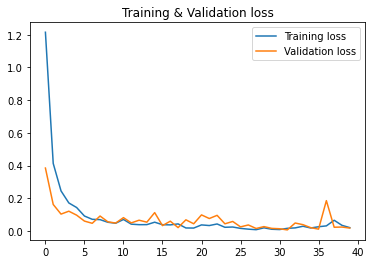

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.title('Training & Validation loss')
plt.show()